# Project 4: XXX
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *03.06.2021* / Last Modified: *27.04.2021*

---

This notebook contains the step-by-step data science process performed *XXX*. The goal of this project was to *XXX*.

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, that provides data for supervised training of classifiers for natural language processing.

## Introduction
---
*XXX*

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p04g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [52]:
%%capture
# uncomment lines with uninstalled packages

#!pip install -U numpy pandas matplotlib seaborn skikit-learn 
!pip install pycontractions
!pip install python-Levenshtein #/root/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.warnings.warn(msg)

In [69]:
# python standard libraries
import json                                            # data transfer to and from json format
import os                                              # access operating system from python
import random                                          # creates randomness
import re                                              # regex search in python

# external libraries
import numpy as np                                     # used for numerical calculations and fast array manipulations
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import matplotlib
import matplotlib.pyplot as plt                        # basic data visualisation
import seaborn as sns                                  # advanced data visualisation
from nltk.tokenize import TweetTokenizer               # tokeniser api
from pycontractions import Contractions                # Intelligently expands and creates contractions in text

In [57]:
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Seaborn Version: {sns.__version__}')
#print(f'Pycontractions Version: {contractions.__version__}') # wont work dont know why?

Numpy Version: 1.19.5
Pandas Version: 1.2.4
Matplotlib Version: 3.4.1
Seaborn Version: 0.11.1


AttributeError: module 'pycontractions.contractions' has no attribute '__version__'

Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [4]:
#from project4.processing import ...
#from project4.save import ...
#from project4.features import ...

## Constants
---
To enhance readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [5]:
DATASETS = ['hate', 'emotion']

# store paths
PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"

# store data 
DATA = {}
for dataset in DATASETS:
    DATA[dataset] = {}

*TASK 0*
# Fetching Data
---

## Loading in Data
---

In [6]:
def read_raw_input(dataset):
    # reading in all .txts into list of strings
    for _file in os.listdir(f'../data/raw/{dataset}'):
        with open(f'../data/raw/{dataset}/{_file}', 'r') as infile:
            DATA[dataset][_file[:-4]] = [line.strip() for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA[dataset][key] = [int(x) for x in DATA[dataset][key]]

    # convert mapping to dictionary
    DATA[dataset]['mapping'] = {int(string.split('\t')[0]): string.split('\t')[1] for string in DATA[dataset]['mapping']}

In [7]:
for dataset in DATASETS:
    read_raw_input(dataset)

## Exploring Data
---

### Peek into Training Tweets

In [8]:
# hate
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['hate']['mapping'][DATA['hate']['train_labels'][i]].title()}\t\t{DATA['hate']['train_text'][i]}")

1	Label: Not-Hate		@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
2	Label: Hate		A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
3	Label: Hate		@user @user real talk do you have eyes or were they gouged out by a rapefugee?
4	Label: Hate		your girlfriend lookin at me like a groupie in this bitch!
5	Label: Not-Hate		Hysterical woman like @user
6	Label: Not-Hate		Me flirting- So tell me about your father...
7	Label: Not-Hate		The Philippine Catholic bishops' work for migrant workers should focus on families who are "paying the great...
8	Label: Hate		I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch
9	Label: Not-Hate		When cuffin season is finally over
10	Label: Hate		Send home migrants not in need of protection, Peter Dutton tells UN, HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NO

In [9]:
# hate
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['emotion']['mapping'][DATA['emotion']['train_labels'][i]].title()}\t\t{DATA['emotion']['train_text'][i]}")

1	Label: Optimism		“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
2	Label: Anger		My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
3	Label: Joy		No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
4	Label: Anger		Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
5	Label: Sadness		it's pretty depressing when u hit pan on ur favourite highlighter
6	Label: Anger		@user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
7	Label: Sadness		Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college
8	Label: Joy		Tiller and breezy should do a collab album. Rapping and singing prolly be fire
9	Label: Anger		@user broadband is shocking regretting signing up now #angry #shouldofgone

### Visualising Label Distribution

In [10]:
def visualise_label_distribution(dataset):
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    fig.suptitle(f'Frequency of Target Label in {dataset.capitalize()}', fontsize=12, fontweight='bold')

    for i, key in enumerate(['train_labels', 'val_labels', 'test_labels']):
        label, count = np.unique(DATA[dataset][key], return_counts=True)
        ax[i].bar(label, count, color='grey');
        ax[i].set_title(key.replace('_', ' ').title())
        ax[i].set_xticks(label); ax[i].set_xticklabels([string.title() for string in DATA[dataset]['mapping'].values()])

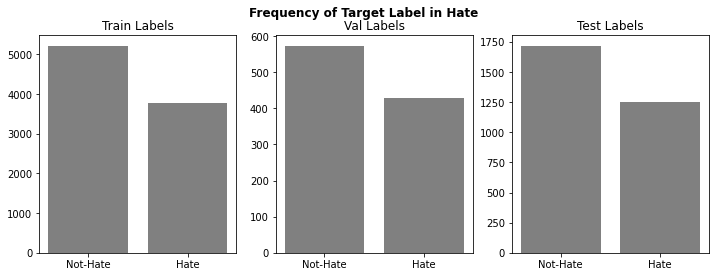

In [11]:
visualise_label_distribution(dataset='hate')

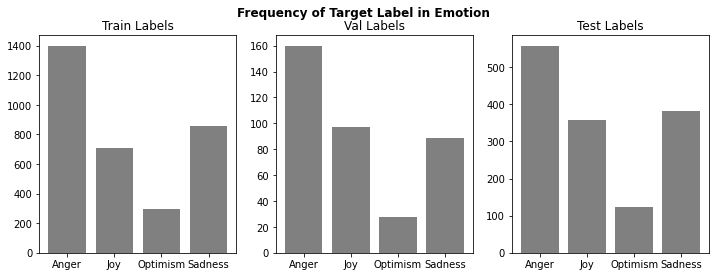

In [12]:
visualise_label_distribution(dataset='emotion')

*TASK 0.5*
# Processing of Language Data
---


### Tokenize Tweets
---


In [13]:
def tokeniser1(tweet):
    return re.findall('\w+', tweet)

In [14]:
def tokeniser2(tweet):
    return re.split(' ', tweet)

In [15]:
def tokeniser3(tweet):
    tk = TweetTokenizer()
    return tk.tokenize(tweet)

In [16]:
def tokeniser4(line):
    # Initialise lists
    tokens = []
    unmatchable = [] # should be emtpy if done nicely

    # Compile patterns for speedup
    token_pat = re.compile('\w+')
    skippable_pat = re.compile('\s+')  # typically spaces

    # As long as there's any material left...
    while line:
        print(line)
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        print(skippable_match)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                print(token_match)
                # If there is one at the beginning of the line, tokenise it.
                tokens.append(line[:token_match.end()])
                line = line[token_match.end():]
            else:
                # Else there is unmatchable material here.
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]

    return tokens

In [17]:
#ex_tweet = DATA['hate']['train_text'][0]
ex_tweet = "https://t.co/9z2J3P33Uc FB needs to hurry up and add a laugh/cry button 😬😭😓🤢🙄😱 Since eating my feelings has not fixed the world's problems, I guess I'll try to sleep... HOLY CRAP: DeVos questionnaire appears to include passages from uncited sources https://t.co/FNRoOlfw9s well played, Senator Murray Keep the pressure on: https://t.co/4hfOsmdk0l @datageneral thx Mr Taussig It's interesting how many people contact me about applying for a PhD and don't @user spell my name #something right."

tokeniser = [tokeniser1, tokeniser2, tokeniser3]

print('Original Tweet: ',ex_tweet, '\n')
for i in range(len(tokeniser)):
    print(f"Tokeniser {i+1}: {tokeniser[i](ex_tweet)}")

Original Tweet:  https://t.co/9z2J3P33Uc FB needs to hurry up and add a laugh/cry button 😬😭😓🤢🙄😱 Since eating my feelings has not fixed the world's problems, I guess I'll try to sleep... HOLY CRAP: DeVos questionnaire appears to include passages from uncited sources https://t.co/FNRoOlfw9s well played, Senator Murray Keep the pressure on: https://t.co/4hfOsmdk0l @datageneral thx Mr Taussig It's interesting how many people contact me about applying for a PhD and don't @user spell my name #something right. 

Tokeniser 1: ['https', 't', 'co', '9z2J3P33Uc', 'FB', 'needs', 'to', 'hurry', 'up', 'and', 'add', 'a', 'laugh', 'cry', 'button', 'Since', 'eating', 'my', 'feelings', 'has', 'not', 'fixed', 'the', 'world', 's', 'problems', 'I', 'guess', 'I', 'll', 'try', 'to', 'sleep', 'HOLY', 'CRAP', 'DeVos', 'questionnaire', 'appears', 'to', 'include', 'passages', 'from', 'uncited', 'sources', 'https', 't', 'co', 'FNRoOlfw9s', 'well', 'played', 'Senator', 'Murray', 'Keep', 'the', 'pressure', 'on', 'h

### Summary
---

Tokeniser 1 (Finds all Words):
+ Good representation of words (includes Unicode characters and is sensible to punctuation within words, ie. "don't")
- Deletes all punctuation (which might be important, ie. twitter communication heavily based tagging using '@' and hastags (#))
- Destroys Links
- Blind to Emojis

Tokeniser 2 (Split at Whitespace):
+ Overall good representation of words 
+ keeps punctuation
- ending punctuation is not being separated
+ keeps Links
+ recognises Emojis
- doesnt separate adjacent emojis 
- blind to several words written together (in slang), ie. idontgiveafuck

Tokeniser 3 (Twitter Tokeniser API, Overcomes issues of Tokeniser 2):
+ Ending punctuation is being separated
+ Separate adjacent Emojis 

### Improving Tokenizer

Improving on the Tweet Tokenizer:
* lowercasing 
* expanding contractions
* change links to a dummy value

Functions: (most likely to combine later)

In [40]:
def lowercase(tokenised_list):
    return [i.lower() for i in tokenised_list]

In [43]:
def rm_links(tokenised_list):
    dummy= "thisisalinkadp2yNQ263fh7fRhGvKw" #randomised password generator used to get a most likely unique string to include
    return [token if token[:8]!="https://" else dummy for token in tokenised_list] #check here later that all links are in fact in this format

In [90]:

# Load your favorite semantic vector model in gensim keyedvectors format from disk
>>> cont = Contractions('GoogleNews-vectors-negative300.bin')

# must download locally will not allow on deepnote as it is a very big file.



In [101]:
def expand(tweet): # may be worth doing first on whole text before tokeniseing
    return tweet

Testing:

In [107]:
print(ex_tweet)
ex_tokenised=tokeniser3(ex_tweet)
print(ex_tokenised)
print(lowercase(ex_tokenised))
print(rm_links(ex_tokenised))
print(expand(ex_tweet)) # does nothing

https://t.co/9z2J3P33Uc FB needs to hurry up and add a laugh/cry button 😬😭😓🤢🙄😱 Since eating my feelings has not fixed the world's problems, I guess I'll try to sleep... HOLY CRAP: DeVos questionnaire appears to include passages from uncited sources https://t.co/FNRoOlfw9s well played, Senator Murray Keep the pressure on: https://t.co/4hfOsmdk0l @datageneral thx Mr Taussig It's interesting how many people contact me about applying for a PhD and don't @user spell my name #something right.
['https://t.co/9z2J3P33Uc', 'FB', 'needs', 'to', 'hurry', 'up', 'and', 'add', 'a', 'laugh', '/', 'cry', 'button', '😬', '😭', '😓', '🤢', '🙄', '😱', 'Since', 'eating', 'my', 'feelings', 'has', 'not', 'fixed', 'the', "world's", 'problems', ',', 'I', 'guess', "I'll", 'try', 'to', 'sleep', '...', 'HOLY', 'CRAP', ':', 'DeVos', 'questionnaire', 'appears', 'to', 'include', 'passages', 'from', 'uncited', 'sources', 'https://t.co/FNRoOlfw9s', 'well', 'played', ',', 'Senator', 'Murray', 'Keep', 'the', 'pressure', 'on

Suggested order:
* lowercase
* contractions # build in later locally or do a simple sometimes wrong version ourselves
* tokenize 
* remove links


## Final Tokenising

In [ ]:
def rm_links(tokenised_list):
    """removes links from tokenised tweets"""
    dummy= "thisisalinkadp2yNQ263fh7fRhGvKw" #randomised password generator used to get a most likely unique string to include
    return [token if token[:8]!="https://" else dummy for token in tokenised_list] #check here later that all links are in fact in this format

In [102]:
def expand(tweet): # build in the ml model for contraciton here later
    return tweet

    # may be easier to contract everything contractable? 

In [103]:
tk = TweetTokenizer()
def clean(tweet):
    lower=tweet.lower()
    contractions=expand(lower)# build in the ml model for contractions here
    tokenised=tk.tokenize(contractions)
    link_dummy=rm_links(tokenised)
    return link_dummy


In [106]:
clean(ex_tweet)

['thisisalinkadp2yNQ263fh7fRhGvKw',
 'fb',
 'needs',
 'to',
 'hurry',
 'up',
 'and',
 'add',
 'a',
 'laugh',
 '/',
 'cry',
 'button',
 '😬',
 '😭',
 '😓',
 '🤢',
 '🙄',
 '😱',
 'since',
 'eating',
 'my',
 'feelings',
 'has',
 'not',
 'fixed',
 'the',
 "world's",
 'problems',
 ',',
 'i',
 'guess',
 "i'll",
 'try',
 'to',
 'sleep',
 '...',
 'holy',
 'crap',
 ':',
 'devos',
 'questionnaire',
 'appears',
 'to',
 'include',
 'passages',
 'from',
 'uncited',
 'sources',
 'thisisalinkadp2yNQ263fh7fRhGvKw',
 'well',
 'played',
 ',',
 'senator',
 'murray',
 'keep',
 'the',
 'pressure',
 'on',
 ':',
 'thisisalinkadp2yNQ263fh7fRhGvKw',
 '@datageneral',
 'thx',
 'mr',
 'taussig',
 "it's",
 'interesting',
 'how',
 'many',
 'people',
 'contact',
 'me',
 'about',
 'applying',
 'for',
 'a',
 'phd',
 'and',
 "don't",
 '@user',
 'spell',
 'my',
 'name',
 '#something',
 'right',
 '.']

*TASK 2*
# XXX
---

In [18]:
# some code

*TASK 3*
# Open Question: XXX
---

In [19]:
# some code

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ea65742-831a-48cd-9d56-a22e1ed66c7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>